# Trial 1 - Protein Trimming Based on Binding Hotspot Analysis

This notebook provides a workflow to trim a target protein based on binding hotspot analysis from failed BindCraft designs.
The goal is to create a smaller, more focused receptor that retains the most frequently targeted binding sites.

**Workflow outline**
1. Load hotspot data from previous analysis
2. Define trimming criteria and parameters
3. Extract high-frequency binding regions
4. Create trimmed protein structure
5. Validate trimmed structure
6. Export for next design round


## 0. Dependencies & Environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Tuple, Set, Dict
import warnings

from Bio.PDB import (
    PDBParser,
    PDBIO,
    Select,
    NeighborSearch,
    is_aa,
    Superimposer,
    Structure,
    Model,
    Chain,
)
from Bio.PDB.Polypeptide import is_aa

warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (10, 8)})

## 1. Configuration and Data Loading

In [2]:
HOTSPOT_PDB = Path("./receptor_hotspots.pdb")
ORIGINAL_RECEPTOR = Path("./data/original_receptor.pdb")
OUTPUT_DIR = Path("./trimmed_proteins")
OUTPUT_DIR.mkdir(exist_ok=True)

# Chain identifiers
RECEPTOR_CHAINS = {'A'}  # Update if your receptor has multiple chains

# Trimming parameters
HOTSPOT_THRESHOLD = 5      # Minimum number of designs that must target a residue
EXPANSION_RADIUS = 8.0     # Expand selected regions by this distance (Å)
MIN_FRAGMENT_SIZE = 15     # Minimum size for continuous fragments
GAP_BRIDGE_DISTANCE = 10   # Bridge gaps smaller than this (in sequence)

## 2. Load and Analyze Hotspot Data

Loaded 475 residues with hotspot data


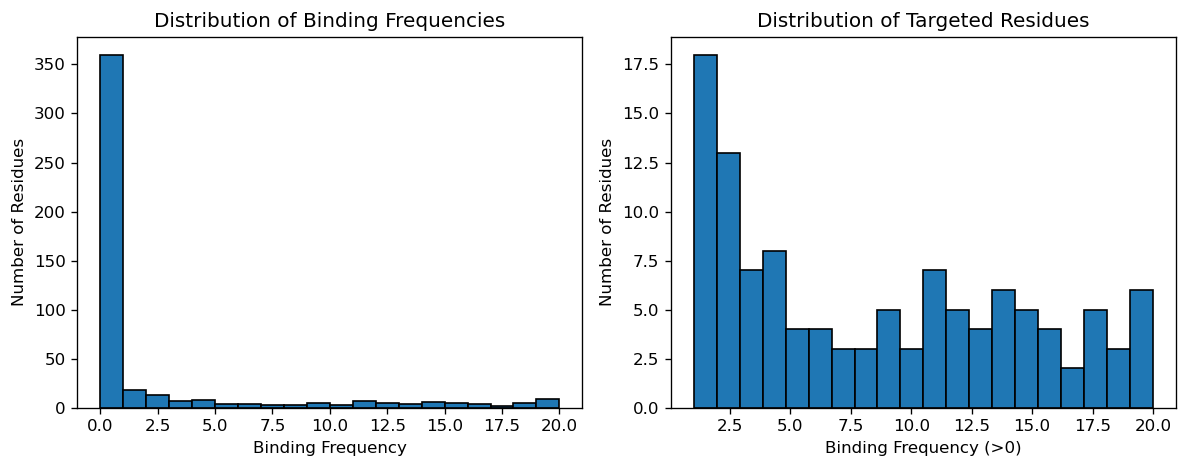

Residues targeted at least once: 115
Residues targeted ≥5 times: 69


In [3]:
parser = PDBParser(QUIET=True)

def extract_hotspot_frequencies(pdb_path):
    """Extract B-factor values representing binding frequencies from hotspot PDB."""
    struct = parser.get_structure('hotspot', pdb_path)
    hotspot_data = {}
    
    for model in struct:
        for chain in model:
            if chain.id not in RECEPTOR_CHAINS:
                continue
            for residue in chain:
                if is_aa(residue, standard=True):
                    # Use average B-factor of all atoms in residue
                    avg_bfactor = np.mean([atom.bfactor for atom in residue])
                    hotspot_data[(chain.id, residue.id[1])] = avg_bfactor
    
    return hotspot_data

# Load hotspot frequencies
hotspot_freq = extract_hotspot_frequencies(HOTSPOT_PDB)
print(f"Loaded {len(hotspot_freq)} residues with hotspot data")

# Analyze distribution
frequencies = list(hotspot_freq.values())
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(frequencies, bins=20, edgecolor='black')
plt.xlabel('Binding Frequency')
plt.ylabel('Number of Residues')
plt.title('Distribution of Binding Frequencies')

plt.subplot(1, 2, 2)
plt.hist([f for f in frequencies if f > 0], bins=20, edgecolor='black')
plt.xlabel('Binding Frequency (>0)')
plt.ylabel('Number of Residues')
plt.title('Distribution of Targeted Residues')
plt.tight_layout()
plt.show()

print(f"Residues targeted at least once: {sum(1 for f in frequencies if f > 0)}")
print(f"Residues targeted ≥{HOTSPOT_THRESHOLD} times: {sum(1 for f in frequencies if f >= HOTSPOT_THRESHOLD)}")

## 3. Identify Core Binding Regions

In [4]:
def get_residue_neighbors(struct, target_res, radius=8.0):
    """Find all residues within radius of target residue."""
    atoms = []
    for model in struct:
        for chain in model:
            if chain.id in RECEPTOR_CHAINS:
                for res in chain:
                    if is_aa(res, standard=True):
                        atoms.extend(res.get_atoms())
    
    ns = NeighborSearch(atoms)
    target_atoms = list(target_res.get_atoms())
    neighbors = set()
    
    for atom in target_atoms:
        nearby = ns.search(atom.coord, radius, level='R')
        neighbors.update(nearby)
    
    return neighbors

def expand_hotspot_regions(struct, core_residues, expansion_radius):
    """Expand core residues to include nearby structural context."""
    expanded = set(core_residues)
    
    for chain_id, res_id in core_residues:
        # Find the residue object
        for model in struct:
            if chain_id in model:
                chain = model[chain_id]
                if res_id in chain:
                    residue = chain[res_id]
                    neighbors = get_residue_neighbors(struct, residue, expansion_radius)
                    for n in neighbors:
                        if n.get_parent().id in RECEPTOR_CHAINS:
                            expanded.add((n.get_parent().id, n.id[1]))
    
    return expanded

# Load original receptor structure
receptor_struct = parser.get_structure('receptor', ORIGINAL_RECEPTOR)

# Identify core hotspot residues
core_residues = {(chain_id, res_id) for (chain_id, res_id), freq in hotspot_freq.items() 
                 if freq >= HOTSPOT_THRESHOLD}

print(f"Core hotspot residues (frequency ≥ {HOTSPOT_THRESHOLD}): {len(core_residues)}")

# Expand to include structural context
expanded_residues = expand_hotspot_regions(receptor_struct, core_residues, EXPANSION_RADIUS)
print(f"Expanded residue set: {len(expanded_residues)}")

Core hotspot residues (frequency ≥ 5): 69
Expanded residue set: 318


## 4. Fragment Analysis and Gap Bridging

In [5]:
def analyze_fragments(residue_set, chain_id='A'):
    """Analyze continuous fragments in the residue set."""
    chain_residues = sorted([res_id for (c_id, res_id) in residue_set if c_id == chain_id])
    
    if not chain_residues:
        return []
    
    fragments = []
    current_fragment = [chain_residues[0]]
    
    for i in range(1, len(chain_residues)):
        if chain_residues[i] - chain_residues[i-1] == 1:
            current_fragment.append(chain_residues[i])
        else:
            fragments.append(current_fragment)
            current_fragment = [chain_residues[i]]
    
    fragments.append(current_fragment)
    return fragments

def bridge_small_gaps(fragments, max_gap=10):
    """Bridge small gaps between fragments."""
    if len(fragments) <= 1:
        return fragments
    
    merged = [fragments[0]]
    
    for i in range(1, len(fragments)):
        last_fragment = merged[-1]
        current_fragment = fragments[i]
        
        gap_size = current_fragment[0] - last_fragment[-1] - 1
        
        if gap_size <= max_gap:
            # Bridge the gap
            bridged = last_fragment + list(range(last_fragment[-1] + 1, current_fragment[0])) + current_fragment
            merged[-1] = bridged
        else:
            merged.append(current_fragment)
    
    return merged

# Analyze fragments for each chain
all_fragments = {}
for chain_id in RECEPTOR_CHAINS:
    fragments = analyze_fragments(expanded_residues, chain_id)
    print(f"\nChain {chain_id} - Initial fragments: {len(fragments)}")
    for i, frag in enumerate(fragments):
        print(f"  Fragment {i+1}: residues {frag[0]}-{frag[-1]} (size: {len(frag)})")
    
    # Bridge small gaps
    bridged_fragments = bridge_small_gaps(fragments, GAP_BRIDGE_DISTANCE)
    print(f"\nAfter bridging gaps ≤ {GAP_BRIDGE_DISTANCE}:")
    for i, frag in enumerate(bridged_fragments):
        print(f"  Fragment {i+1}: residues {frag[0]}-{frag[-1]} (size: {len(frag)})")
    
    # Filter by minimum size
    final_fragments = [f for f in bridged_fragments if len(f) >= MIN_FRAGMENT_SIZE]
    print(f"\nAfter filtering (min size {MIN_FRAGMENT_SIZE}): {len(final_fragments)} fragments")
    
    all_fragments[chain_id] = final_fragments


Chain A - Initial fragments: 28
  Fragment 1: residues 28-100 (size: 73)
  Fragment 2: residues 104-105 (size: 2)
  Fragment 3: residues 107-203 (size: 97)
  Fragment 4: residues 206-207 (size: 2)
  Fragment 5: residues 219-219 (size: 1)
  Fragment 6: residues 221-222 (size: 2)
  Fragment 7: residues 225-227 (size: 3)
  Fragment 8: residues 229-231 (size: 3)
  Fragment 9: residues 235-235 (size: 1)
  Fragment 10: residues 239-239 (size: 1)
  Fragment 11: residues 248-250 (size: 3)
  Fragment 12: residues 252-264 (size: 13)
  Fragment 13: residues 266-287 (size: 22)
  Fragment 14: residues 292-292 (size: 1)
  Fragment 15: residues 296-298 (size: 3)
  Fragment 16: residues 303-304 (size: 2)
  Fragment 17: residues 307-317 (size: 11)
  Fragment 18: residues 320-320 (size: 1)
  Fragment 19: residues 322-355 (size: 34)
  Fragment 20: residues 358-358 (size: 1)
  Fragment 21: residues 362-366 (size: 5)
  Fragment 22: residues 371-371 (size: 1)
  Fragment 23: residues 374-391 (size: 18)
  Fr

## 5. Create Trimmed Structure

In [7]:
class TrimmedProteinSelect(Select):
    """Selection class for creating trimmed protein."""
    def __init__(self, selected_residues):
        self.selected_residues = selected_residues
    
    def accept_residue(self, residue):
        chain_id = residue.get_parent().id
        res_id = residue.id[1]
        return (chain_id, res_id) in self.selected_residues

def create_trimmed_structure(struct, fragments_dict):
    """Create trimmed structure based on selected fragments."""
    selected_residues = set()
    
    for chain_id, fragments in fragments_dict.items():
        for fragment in fragments:
            for res_id in fragment:
                selected_residues.add((chain_id, res_id))
    
    return selected_residues

# Create final residue selection
final_residues = create_trimmed_structure(receptor_struct, all_fragments)
print(f"\nTotal residues in trimmed structure: {len(final_residues)}")

# Calculate reduction
original_residue_count = sum(1 for model in receptor_struct for chain in model 
                           for res in chain if is_aa(res, standard=True))
reduction_percent = (1 - len(final_residues) / original_residue_count) * 100
print(f"Size reduction: {reduction_percent:.1f}%")



Total residues in trimmed structure: 382
Size reduction: 19.6%


## 6. Visualize Trimming Results

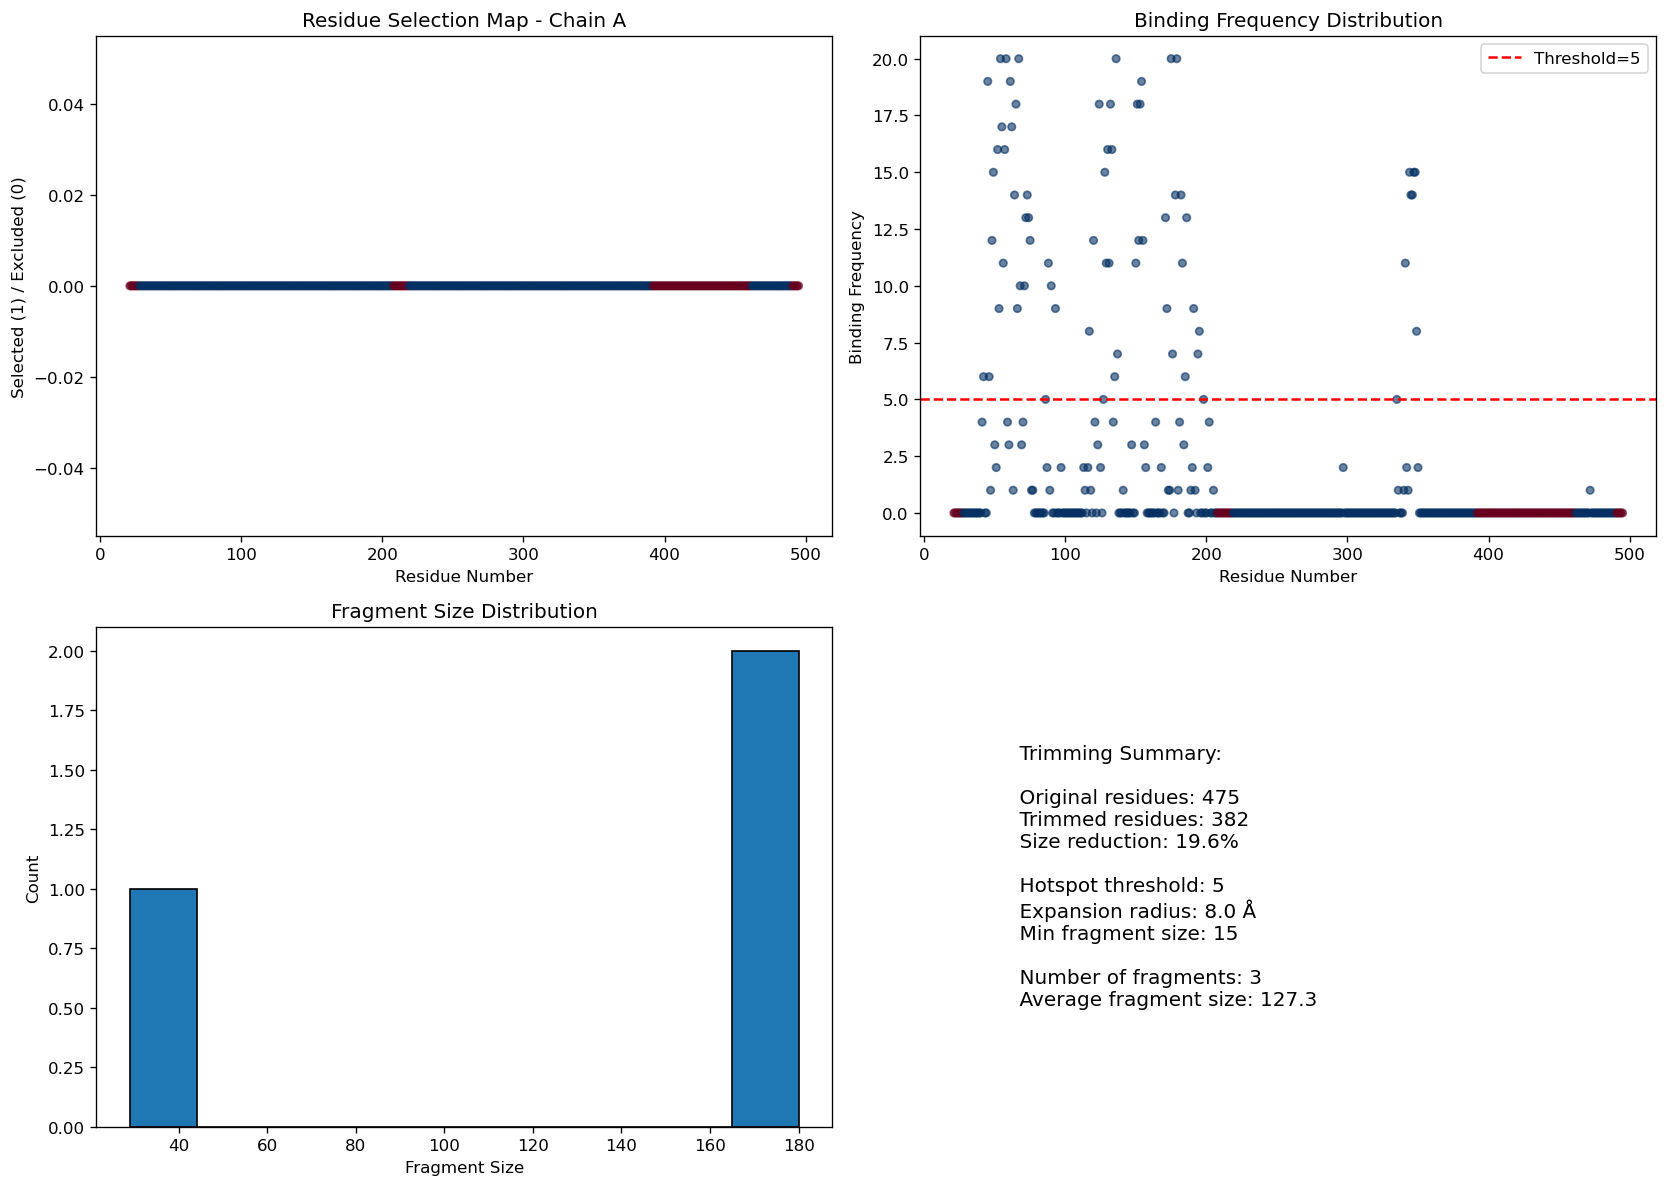

In [8]:
def create_trimming_report(struct, selected_residues, hotspot_freq):
    """Create visualization of trimming results."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Residue selection map
    ax = axes[0, 0]
    for chain_id in RECEPTOR_CHAINS:
        chain_res = []
        selected = []
        frequencies = []
        
        for model in struct:
            if chain_id in model:
                chain = model[chain_id]
                for res in chain:
                    if is_aa(res, standard=True):
                        res_id = res.id[1]
                        chain_res.append(res_id)
                        selected.append(1 if (chain_id, res_id) in selected_residues else 0)
                        frequencies.append(hotspot_freq.get((chain_id, res_id), 0))
        
        if chain_res:
            ax.scatter(chain_res, [0] * len(chain_res), c=selected, cmap='RdBu', s=20, alpha=0.6)
            ax.set_xlabel('Residue Number')
            ax.set_ylabel('Selected (1) / Excluded (0)')
            ax.set_title(f'Residue Selection Map - Chain {chain_id}')
    
    # 2. Hotspot frequency along sequence
    ax = axes[0, 1]
    ax.scatter(chain_res, frequencies, c=selected, cmap='RdBu', s=20, alpha=0.6)
    ax.axhline(y=HOTSPOT_THRESHOLD, color='red', linestyle='--', label=f'Threshold={HOTSPOT_THRESHOLD}')
    ax.set_xlabel('Residue Number')
    ax.set_ylabel('Binding Frequency')
    ax.set_title('Binding Frequency Distribution')
    ax.legend()
    
    # 3. Fragment size distribution
    ax = axes[1, 0]
    fragment_sizes = []
    for chain_id, fragments in all_fragments.items():
        fragment_sizes.extend([len(f) for f in fragments])
    
    ax.hist(fragment_sizes, bins=10, edgecolor='black')
    ax.set_xlabel('Fragment Size')
    ax.set_ylabel('Count')
    ax.set_title('Fragment Size Distribution')
    
    # 4. Summary statistics
    ax = axes[1, 1]
    ax.axis('off')
    summary_text = f"""
    Trimming Summary:
    
    Original residues: {original_residue_count}
    Trimmed residues: {len(selected_residues)}
    Size reduction: {reduction_percent:.1f}%
    
    Hotspot threshold: {HOTSPOT_THRESHOLD}
    Expansion radius: {EXPANSION_RADIUS} Å
    Min fragment size: {MIN_FRAGMENT_SIZE}
    
    Number of fragments: {sum(len(f) for f in all_fragments.values())}
    Average fragment size: {np.mean(fragment_sizes):.1f}
    """
    ax.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    return fig

# Create report
report_fig = create_trimming_report(receptor_struct, final_residues, hotspot_freq)
plt.savefig(OUTPUT_DIR / 'trimming_report.png', dpi=300)
plt.show()

## 7. Export Trimmed Structure

In [9]:
def renumber_residues(selected_residues, chain_id):
    """Optionally renumber residues to be continuous."""
    chain_residues = sorted([res_id for (c_id, res_id) in selected_residues if c_id == chain_id])
    renumber_map = {old_id: new_id for new_id, old_id in enumerate(chain_residues, 1)}
    return renumber_map

# Save trimmed structure
io = PDBIO()
io.set_structure(receptor_struct)

# Save with original numbering
select = TrimmedProteinSelect(final_residues)
io.save(str(OUTPUT_DIR / 'trimmed_receptor_original_numbering.pdb'), select)
print(f"Saved: trimmed_receptor_original_numbering.pdb")

# Also save a version with hotspot scores in B-factor column
trimmed_struct = parser.get_structure('trimmed', OUTPUT_DIR / 'trimmed_receptor_original_numbering.pdb')
for model in trimmed_struct:
    for chain in model:
        for residue in chain:
            freq = hotspot_freq.get((chain.id, residue.id[1]), 0)
            for atom in residue:
                atom.bfactor = freq

io.set_structure(trimmed_struct)
io.save(str(OUTPUT_DIR / 'trimmed_receptor_with_scores.pdb'))
print(f"Saved: trimmed_receptor_with_scores.pdb")


Saved: trimmed_receptor_original_numbering.pdb
Saved: trimmed_receptor_with_scores.pdb


## 8. Export Metadata for Next Design Round

In [10]:
# Create metadata for the trimmed structure
metadata = {
    'original_receptor': str(ORIGINAL_RECEPTOR),
    'trimming_parameters': {
        'hotspot_threshold': HOTSPOT_THRESHOLD,
        'expansion_radius': EXPANSION_RADIUS,
        'min_fragment_size': MIN_FRAGMENT_SIZE,
        'gap_bridge_distance': GAP_BRIDGE_DISTANCE
    },
    'statistics': {
        'original_residue_count': original_residue_count,
        'trimmed_residue_count': len(final_residues),
        'size_reduction_percent': reduction_percent,
        'num_fragments': sum(len(f) for f in all_fragments.values()),
        'fragment_sizes': [len(f) for chain_frags in all_fragments.values() for f in chain_frags]
    },
    'fragments': {
        chain_id: [[f[0], f[-1], len(f)] for f in fragments]
        for chain_id, fragments in all_fragments.items()
    },
    'high_frequency_residues': [
        {
            'chain': chain_id,
            'residue': res_id,
            'frequency': freq
        }
        for (chain_id, res_id), freq in hotspot_freq.items()
        if freq >= HOTSPOT_THRESHOLD and (chain_id, res_id) in final_residues
    ]
}

import json
with open(OUTPUT_DIR / 'trimming_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("Saved: trimming_metadata.json")

Saved: trimming_metadata.json


## 9. Validation and Recommendations

In [11]:
print("\n" + "="*60)
print("TRIMMING COMPLETE - RECOMMENDATIONS FOR NEXT DESIGN ROUND:")
print("="*60)

print(f"\n1. The trimmed receptor has been reduced to {len(final_residues)} residues ({reduction_percent:.1f}% reduction)")
print(f"   This should significantly reduce computational cost and improve sampling efficiency.")

print(f"\n2. The trimmed structure contains {sum(len(f) for f in all_fragments.values())} continuous fragments:")
for chain_id, fragments in all_fragments.items():
    print(f"   Chain {chain_id}:")
    for i, frag in enumerate(fragments):
        print(f"     Fragment {i+1}: residues {frag[0]}-{frag[-1]} ({len(frag)} residues)")

print("\n3. High-confidence binding sites (targeted by ≥{} designs):".format(HOTSPOT_THRESHOLD))
high_freq_sites = [(chain_id, res_id, freq) for (chain_id, res_id), freq in hotspot_freq.items() 
                   if freq >= HOTSPOT_THRESHOLD and (chain_id, res_id) in final_residues]
high_freq_sites.sort(key=lambda x: x[2], reverse=True)
for chain_id, res_id, freq in high_freq_sites[:10]:  # Show top 10
    print(f"   Chain {chain_id} Residue {res_id}: {freq:.0f} designs")

print("\n4. Next steps:")
print("   - Use 'trimmed_receptor_original_numbering.pdb' as the target for the next BindCraft run")
print("   - Consider using 'trimmed_receptor_with_scores.pdb' to visualize hotspots in PyMOL")
print("   - The B-factor column contains binding frequencies for visualization")
print("   - Review 'trimming_metadata.json' for detailed fragment information")

print("\n5. Additional considerations:")
print("   - The expansion radius of {:.1f} Å ensures structural context is preserved".format(EXPANSION_RADIUS))
print("   - Small gaps (≤{} residues) have been bridged to maintain structural integrity".format(GAP_BRIDGE_DISTANCE))
print("   - You may want to manually inspect the trimmed structure for any critical features")


TRIMMING COMPLETE - RECOMMENDATIONS FOR NEXT DESIGN ROUND:

1. The trimmed receptor has been reduced to 382 residues (19.6% reduction)
   This should significantly reduce computational cost and improve sampling efficiency.

2. The trimmed structure contains 3 continuous fragments:
   Chain A:
     Fragment 1: residues 28-207 (180 residues)
     Fragment 2: residues 219-391 (173 residues)
     Fragment 3: residues 462-490 (29 residues)

3. High-confidence binding sites (targeted by ≥5 designs):
   Chain A Residue 54: 20 designs
   Chain A Residue 58: 20 designs
   Chain A Residue 67: 20 designs
   Chain A Residue 136: 20 designs
   Chain A Residue 175: 20 designs
   Chain A Residue 179: 20 designs
   Chain A Residue 45: 19 designs
   Chain A Residue 61: 19 designs
   Chain A Residue 154: 19 designs
   Chain A Residue 65: 18 designs

4. Next steps:
   - Use 'trimmed_receptor_original_numbering.pdb' as the target for the next BindCraft run
   - Consider using 'trimmed_receptor_with_score

## 10. Optional: Create Multiple Trimming Variants

For experimentation, you might want to create multiple trimmed versions with different parameters.

In [12]:
def create_trimming_variant(name, hotspot_thresh, expand_radius, min_frag_size, gap_bridge):
    """Create a trimming variant with specified parameters."""
    # Identify core residues with new threshold
    core = {(chain_id, res_id) for (chain_id, res_id), freq in hotspot_freq.items() 
            if freq >= hotspot_thresh}
    
    # Expand
    expanded = expand_hotspot_regions(receptor_struct, core, expand_radius)
    
    # Fragment analysis
    variant_fragments = {}
    for chain_id in RECEPTOR_CHAINS:
        frags = analyze_fragments(expanded, chain_id)
        bridged = bridge_small_gaps(frags, gap_bridge)
        final = [f for f in bridged if len(f) >= min_frag_size]
        variant_fragments[chain_id] = final
    
    # Create selection
    selected = create_trimmed_structure(receptor_struct, variant_fragments)
    
    # Save
    io = PDBIO()
    io.set_structure(receptor_struct)
    select = TrimmedProteinSelect(selected)
    output_path = OUTPUT_DIR / f'trimmed_receptor_{name}.pdb'
    io.save(str(output_path), select)
    
    return len(selected), len(selected) / original_residue_count * 100

# Create a few variants
variants = [
    ("conservative", 7, 10.0, 20, 15),
    ("moderate", 5, 8.0, 15, 10),
    ("aggressive", 3, 6.0, 10, 5),
]

print("\n" + "="*60)
print("TRIMMING VARIANTS:")
print("="*60)

for name, thresh, radius, min_size, gap in variants:
    size, percent = create_trimming_variant(name, thresh, radius, min_size, gap)
    print(f"{name:12} - {size:4} residues ({percent:5.1f}% of original)")

print("\nAll variants saved to:", OUTPUT_DIR)


TRIMMING VARIANTS:
conservative -  401 residues ( 84.4% of original)
moderate     -  382 residues ( 80.4% of original)
aggressive   -  310 residues ( 65.3% of original)

All variants saved to: trimmed_proteins
